# A very simple Python implementation of forward-forward NN training by G. Hinton

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

iris = datasets.load_iris()

In [2]:
# learning rate
LR = 1e-1

define an activation function to use and its derivative (needed to compute derivatives for updating weights). Hinton suggested relu-activated network, but in the experiments sigmoid seem to work better

In [3]:
def act(x):
    return 1/(1+np.exp(-x))

def act_prime(x):
    return act(x) * (1 - act(x))

# def act(x):
#     return np.maximum(x, 0.0)

# def act_prime(x):
#     return (x > 0).astype(float)

this is a very simple class for fully-connected layer, holding weights and biases + implementing gradient computation. Gradient computation method assumes that "goodness" function is sum of squared activations

In [4]:
class FullyConnected():
    def __init__(self, n_in, n_out):
        self.W = np.random.normal(size=(n_out, n_in))
        self.b = np.zeros(n_out)
        self.gradW = None
        self.gradb = None
        
    def forward(self, x):
        z = self.W@x + self.b
        return act(z)
    
    def grads(self, x):
        z = self.W@x + self.b
        return (2*(act_prime(z)*act(z))[:, None] @ x[None,:]), 2*act(z)*act_prime(z)

    def update(self, x, accumulate=True, neg=False):
        """ when accumulate is true, accumulates the gradients,
        otherwise applies them to the weights
        """
        k = 1
        if neg:
            k = -1
        if self.gradW is None:
            self.gradW, self.gradb = self.grads(x)
        else:
            dW, db = self.grads(x)
            self.gradW += dW
            self.gradb += db
        if not accumulate:
            self.W += k*LR*self.gradW
            self.b += k*LR*self.gradb
            self.gradW, self.gradb = None, None
        return 

In [5]:
class ForwForwNet:
    def __init__(self, inp_width, hidden_width, n_layers):
        self.layers = []
        for i in range(n_layers):
            if i == 0:
                self.layers.append(FullyConnected(inp_width, hidden_width))
            else:
                self.layers.append(FullyConnected(hidden_width, hidden_width))
        
    def forward(self, x):
        """ performs forward pass by calculating activation of every layer,
        normalizing activation vector by its norm and passing it to the
        next layer
        """
        prev_act = x
        acts = []
        for l in self.layers:
            act = l.forward(prev_act / np.linalg.norm(prev_act+1e-9))
            acts.append(act)
            prev_act = act
        return acts
    
    def update(self, x, accumulate=True, neg=False):
        """ greedily updates weights of the network by 
        calling update on every layer 
        """
        acts = self.forward(x)
        for a, l in zip([x, *acts[:-1]], self.layers):
            l.update(a / np.linalg.norm(a+1e-9), neg=neg, accumulate=accumulate)
            
    def goodness(self, x):
        return (np.array(self.forward(x))**2).sum()

load the Iris data and make some preprocessing

In [6]:
Y = iris['target']
X = StandardScaler().fit_transform(iris['data'])
# generate good labels by one-hot encoding original labels
ohe = OneHotEncoder(sparse=False)
Ygood = ohe.fit_transform(Y[:,None]) - 0.5

unq = np.unique(Y)
# generate bad labels by one-hot encoding wrong labels
Ybad = []
for label in unq:
    Ybad.append(np.random.choice(unq[unq!=label], size=50))
Ybad = ohe.transform(np.concatenate(Ybad)[:, None]) - 0.5

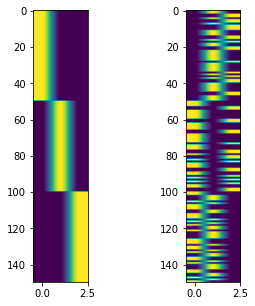

In [7]:
plt.figure(figsize=(5, 5))
plt.subplot(1, 2, 1)
plt.imshow(Ygood, aspect=0.1)
plt.subplot(1, 2, 2)
plt.imshow(Ybad, aspect=0.1)

generate input data by concatenating X and Y

In [8]:
Xgood = np.hstack([X, Ygood])
Xbad = np.hstack([X, Ybad])

and finally instantiate network

In [9]:
ffn = ForwForwNet(inp_width=7, hidden_width=128, n_layers=4)

define a helper function which would scan through possible labels and return the label with maximum goodness

In [10]:
unq_oh = ohe.transform(unq[:,None])

def get_preds(x):
    return unq_oh[np.argmax([ffn.goodness(np.array([*x, *y_])) for y_ in unq_oh])]

In [11]:
X_train, X_test, X_good_train, _, X_bad_train, _, Y_train, Y_test = train_test_split(X, Xgood, Xbad, Y)

In [12]:
for i in range(100):
    # pass 1: "good pass": update the weights for good data
    # note that weights are only updated once after gradients for the
    # whole dataset is accumulated, i.e. batch_size == dataset size
    for x in X_good_train:
        ffn.update(x, accumulate=True)
    ffn.update(x, accumulate=False) # this is actual step
    good = ffn.goodness(x)

    # pass 2: "bad pass": update the weights for bad data
    # again, weights are only updated once after gradients for the
    # whole dataset is accumulated, i.e. batch_size == dataset size
    for x in X_bad_train:
        ffn.update(x, accumulate=True, neg=True)
    ffn.update(x, accumulate=False, neg=True)
    bad = ffn.goodness(x)
#     print(good, bad)
    #print statistics
    if i % 10 == 0:
        print("train_acc:", np.mean(np.argmax([get_preds(x) for x in X_train], 1) == Y_train))
        print("val_acc:", np.mean(np.argmax([get_preds(x) for x in X_test], 1) == Y_test))

train_acc: 0.33035714285714285
val_acc: 0.34210526315789475
train_acc: 0.48214285714285715
val_acc: 0.47368421052631576
train_acc: 0.6785714285714286
val_acc: 0.6052631578947368
train_acc: 0.7589285714285714
val_acc: 0.7105263157894737
train_acc: 0.8214285714285714
val_acc: 0.868421052631579
train_acc: 0.9196428571428571
val_acc: 0.8947368421052632
train_acc: 0.9375
val_acc: 0.8947368421052632
train_acc: 0.9464285714285714
val_acc: 0.9473684210526315
train_acc: 0.9553571428571429
val_acc: 0.9210526315789473
train_acc: 0.9553571428571429
val_acc: 0.9473684210526315


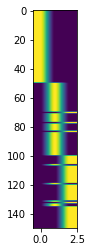

In [13]:
plt.imshow(np.array([get_preds(x) for x in X]), aspect=0.1)